# Install Segment Anything Model

In [9]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-s66d_mqe
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-s66d_mqe
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [10]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision

# https://pytorch.org/vision/stable/transforms.html
from torchvision import transforms as pth_transforms

#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
from torch.utils.data import Dataset, DataLoader

# https://docs.python.org/3/library/glob.html
import glob

from PIL import Image

from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor

In [11]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''




"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## Torch Dataset
[Creating a Custom Dataset for your files](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

In [12]:
class SportsClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # /kaggle/input/sports-classification/train / anything(*) / anything(*).jpg
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*', '*.jpg')))
#         print(self.image_paths) # list of all path

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

##  Augmentation
[Transforms scriptability](https://pytorch.org/vision/stable/transforms.html#transforms-scriptability)

In [13]:
train_root_dir = os.path.join("/kaggle/input/sports-classification/train")
valid_root_dir = os.path.join("/kaggle/input/sports-classification/valid")

train_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train_transform = pth_transforms.Compose([
#     pth_transforms.ToTensor(),
# ])

valid_transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load Training and Validation dataset
train_dataset = SportsClassificationDataset(root_dir=train_root_dir, transform=train_transform)
valid_dataset = SportsClassificationDataset(root_dir=valid_root_dir, transform=valid_transform)

Number of images: 13492
Number of images: 500


**Dataset** stores the samples and their corresponding labels, and 

**DataLoader** wraps an iterable around the Dataset to enable easy access to the samples.

## Dataloader

DataLoader is an iterable that abstracts this complexity for us in an easy API.

[Preparing your data for training with DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size= 8, shuffle=True, num_workers = 2)

# Initialize SAM

**SAM GitHub**
[Notebook_Example](https://github.com/facebookresearch/segment-anything/tree/main/notebooks)

In [20]:
sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# perdictor
predictor = SamPredictor(sam)

# mask generator
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

In [21]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    



def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
        
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    polygons = []
    color = []
    
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        
        for i in range(3):
            img[:,:,i] = color_mask[i]
            
        ax.imshow(np.dstack((img, m**0.5)))


In [25]:
import random
num_images = 10
random_indices = random.sample(range(len(train_dataset)), num_images)
image_tensor= train_dataset[0]
image_path = "/kaggle/input/sports-classification/test/air hockey/3.jpg"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))


predictor.set_image(image)
masks = mask_generator.generate(image)

In [26]:
image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask

(256, 256, 3)


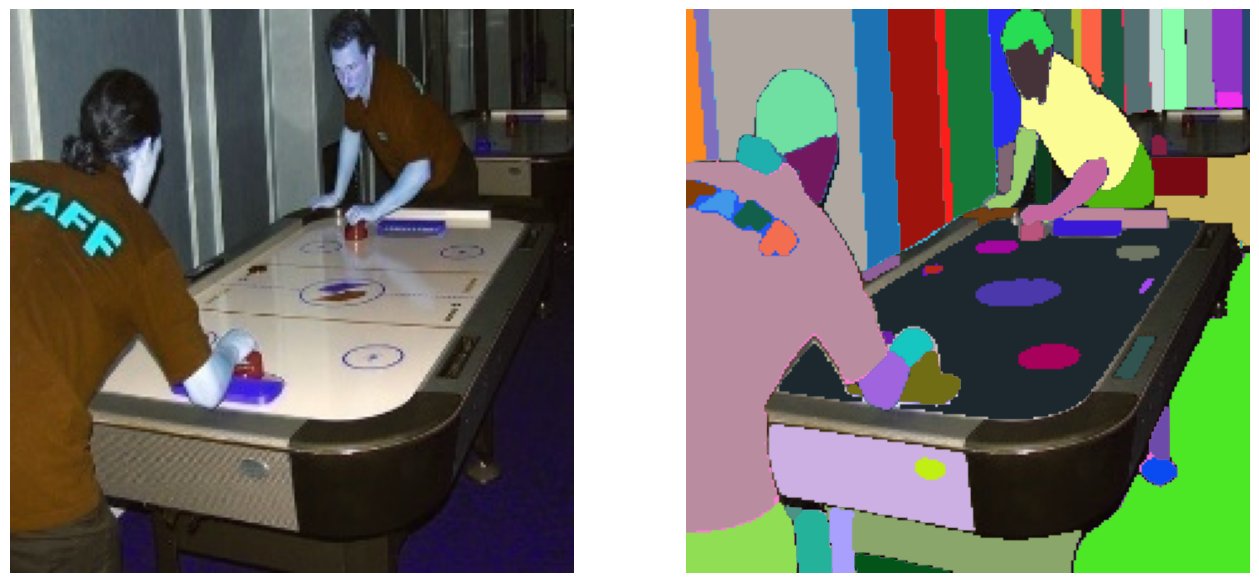

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()